## Video Background Extraction

In [44]:
# packages
import numpy as np
import imageio # manage image
from moviepy.editor import * # manage video
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
import time
from PIL import Image

In [45]:
# BackgroundExtraction Class
class BackExtract:
    def __init__(self, fileName):
        self.clip = VideoFileClip(fileName) # video file
        self.duration = self.clip.duration # length of video
        self.totalFrame = None
        self.frameShape = None
        self.powerTol = None
        np.set_printoptions(threshold=np. inf)
     
    def compare(self, tol):
        self.powerTol = tol
        start_home = time.time() # execute homemade algo and get time
        B_homemade = self.getMatrixB("homemade")
        end_home = time.time()
        time_home = end_home - start_home
 
        start_stand = time.time() # execute standard algo and get time
        B_standard = self.getMatrixB("standard")
        end_stand = time.time()
        time_stand = end_stand - start_stand

        deltaB = B_homemade - B_standard
        totalError = np.linalg.norm(deltaB)
        normOfStandard = np.linalg.norm(B_standard)
        print("Total Error:", totalError)
        print("Error rate compared to standard package:")
        print(totalError/normOfStandard*100, "%")
        print("Time for homemade power iterations:", time_home)
        print("Time for standard svd:", time_stand)
        print("Output (standard, homemade):")


        plt.figure(1)
        plt.axis('off')
        plt.imshow(B_standard)   
        plt.figure(2)
        plt.axis('off')
        plt.imshow(B_homemade)
        
    def ouputBackground(self, algo, tol):
        self.powerTol = tol
        B = self.getMatrixB(algo)
        plt.axis('off')
        plt.imshow(B)

    def getMatrixA(self): # O(mn)
        start_reshape = time.time()
        Mlist = list(self.clip.iter_frames())
        self.totalFrame = len(Mlist)
        # self.totalFrame = 10
        print("Total Frame Number:", self.totalFrame)

        M = Mlist[0] # initialization, get data at time 0
        # M = self.clip.get_frame(0)
        M = Image.fromarray(M).resize((640,360))
        M = np.array(M)
        self.frameShape = M.shape
        Mr, Mg, Mb = self.rgbDecompose(M)
        m = self.frameShape[0]
        n = self.frameShape[1]
        reshapedLen = m*n
 
        Ar = Mr.reshape((reshapedLen,1))
        Ag = Mg.reshape((reshapedLen,1))
        Ab = Mb.reshape((reshapedLen,1))
 
        for i in range(1, self.totalFrame): 
            M = Mlist[i]
            # M = self.clip.get_frame(i)
            M = Image.fromarray(M).resize((640,360))
            M = np.array(M)
            Mr, Mg, Mb = self.rgbDecompose(M)
            mr = Mr.reshape((reshapedLen, 1))
            Ar = np.concatenate((Ar,mr), axis=1)
            mg = Mg.reshape((reshapedLen, 1))
            Ag = np.concatenate((Ag, mg), axis=1)
            mb = Mb.reshape((reshapedLen, 1))
            Ab = np.concatenate((Ab, mb), axis=1)
            if i%50==0:
                print("Finish reshaping frame:",i)
        end_reshape = time.time()
        print("Matrix A got.")
        print("Reshaping Time:",end_reshape - start_reshape)
        self.Ar = Ar
        self.Ag = Ag
        self.Ab = Ab

    def getMatrixB(self, algo): # First try the method of ATA
        AList = [self.Ar, self.Ag, self.Ab] # framing & reshaping
        BList = []
        for i in range(3): # calculate B for each color
            A = AList[i]
            v = self.coreAlgori(A, algo)
            B_vector = v[0]* (A @ v)
            B = B_vector.reshape((self.frameShape[0], self.frameShape[1]))
            BList.append(B)
        B = self.rgbCombine(BList,True)
        return B
    
    def coreAlgori(self, A, algo):
        # search for largest singular value and corresponding v vector             
        if algo == "standard": # sparse matrix algorithm
            U, eigenvalues, V = svds(A) 
            maxEig = max(eigenvalues)
            for index in range(len(eigenvalues)):
                eig = eigenvalues[index]
                if eig == maxEig:
                    v = V[index] # 1 dim 
        
        elif algo == "homemade": # construct B matrix algorithm
            v, sigma = self.power_Method(A)
        return v

    def power_Method(self, A):
        print("power iteration start")
        # Create Variables
        m, n = self.frameShape[0], self.frameShape[1]
        s = self.totalFrame
        x_at = np.zeros((m*n, 1))
        x_at[0][0] = 1
        x_a = np.zeros((s, 1))
        x_a[0][0] = 1
        sigma_former = 100000000
        e = self.powerTol
        itr = 0

        # Initializations
        x = np.concatenate((A.T @ x_at, A @ x_a), axis=0) 
        x = x / np.linalg.norm(x) # get normalized x, k=1
        x_a = x[:s]
        x_at = x[s:]
        Ax = np.concatenate((A.T @ x_at, A @ x_a), axis=0) # get unnormalized x, k=2
        sigma_current = x.T @ Ax # get first sigma
        diff = abs(sigma_current - sigma_former) # get first difference to enter loop
        # Main Loop
        while diff >= e:
            itr += 1
            x = Ax
            x = x / np.linalg.norm(x) # normalize former x
            x_a = x[:s]
            x_at = x[s:]
            Ax = np.concatenate((A.T @ x_at, A @ x_a), axis=0) # calculate x for next iter, unnormalized
            sigma_current = x.T @ Ax
            diff = abs(sigma_current - sigma_former)
            sigma_former = sigma_current
        print("Power iteration converged.")
        x = Ax / np.linalg.norm(Ax)
        v = x[:s] # x_a
        u = x[s:] # x_at
        return v, sigma_current    
        
    def rgbDecompose(self, M): # O(mn)
        # The shape of M will be (m,n,3)
        m, n = M.shape[0], M.shape[1]
        Mr = np.zeros((m, n))
        Mg = np.zeros((m, n))
        Mb = np.zeros((m, n))
        # Decomposition
        for i in range(m):
            for j in range(n):
                Mr[i][j] = M[i][j][0]
                Mg[i][j] = M[i][j][1]
                Mb[i][j] = M[i][j][2]
        return Mr, Mg, Mb

    def rgbCombine(self, img_list, scale=False):
        m, n = self.frameShape[0], self.frameShape[1]
        zero_matrix = np.zeros((m, n, 3))
        if scale:
            upperB = [np.max(img_list[k]) for k in range(3)]
            lowerB = [np.min(img_list[k]) for k in range(3)]
            for i in range(m):
                for j in range(n):
                    for k in range(3):
                        value = (img_list[k][i][j] - lowerB[k]) / (upperB[k] - lowerB[k])
                        zero_matrix[i][j][k] = value
        else:
            for i in range(m):
                for j in range(n):
                    for k in range(3):
                        zero_matrix[i][j][k] = img_list[k][i][j]
        return zero_matrix




640x360

In [49]:
sanfran1 = BackExtract("sanfrancisco_01.mp4")
sanfran1.getMatrixA()

Total Frame Number: 351
Finish reshaping frame: 50
Finish reshaping frame: 100
Finish reshaping frame: 150
Finish reshaping frame: 200
Finish reshaping frame: 250
Finish reshaping frame: 300
Finish reshaping frame: 350
Matrix A got.
Reshaping Time: 294.7724885940552


power iteration start
Power iteration converged.
power iteration start
Power iteration converged.
power iteration start
Power iteration converged.
Total Error: 1.4078147775365308e-07
Error rate compared to standard package:
3.4792062621453765e-08 %
Time for homemade power iterations: 4.076843738555908
Time for standard svd: 15.975144624710083
Output (standard, homemade):


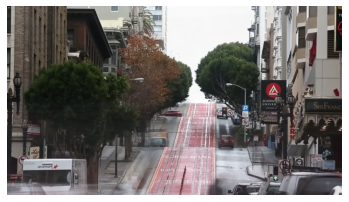

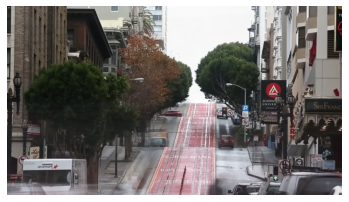

In [50]:
sanfran1.compare(1e-8)

1280x720

In [51]:
pede = BackExtract("pedestrians.mp4")
pede.getMatrixA()

Total Frame Number: 393
Finish reshaping frame: 50
Finish reshaping frame: 100
Finish reshaping frame: 150
Finish reshaping frame: 200
Finish reshaping frame: 250
Finish reshaping frame: 300
Finish reshaping frame: 350
Matrix A got.
Reshaping Time: 303.73694252967834


power iteration start
Power iteration converged.
power iteration start
Power iteration converged.
power iteration start
Power iteration converged.
Total Error: 2.3652323171108493e-08
Error rate compared to standard package:
5.518374749339958e-09 %
Time for homemade power iterations: 4.390254259109497
Time for standard svd: 13.854305505752563
Output (standard, homemade):


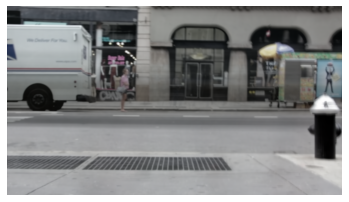

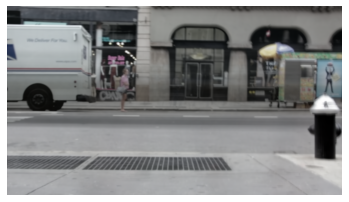

In [52]:
pede.compare(1e-8)

1920x1080

In [56]:
rooster = BackExtract("rooster_01.mp4")
rooster.getMatrixA()

Total Frame Number: 345
Finish reshaping frame: 50
Finish reshaping frame: 100
Finish reshaping frame: 150
Finish reshaping frame: 200
Finish reshaping frame: 250
Finish reshaping frame: 300
Matrix A got.
Reshaping Time: 240.1275999546051


power iteration start
Power iteration converged.
power iteration start
Power iteration converged.
power iteration start
Power iteration converged.
Total Error: 1.375488905288598e-07
Error rate compared to standard package:
3.448603646017484e-08 %
Time for homemade power iterations: 3.3777482509613037
Time for standard svd: 10.439974308013916
Output (standard, homemade):


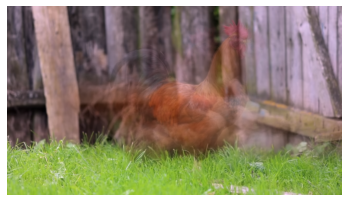

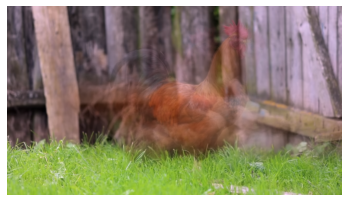

In [57]:
rooster.compare(1e-8)

2560x1440

In [53]:
people2 = BackExtract("people_02.mp4")
people2.getMatrixA()

Total Frame Number: 241
Finish reshaping frame: 50
Finish reshaping frame: 100
Finish reshaping frame: 150
Finish reshaping frame: 200
Matrix A got.
Reshaping Time: 146.21591186523438


power iteration start
Power iteration converged.
power iteration start
Power iteration converged.
power iteration start
Power iteration converged.
Total Error: 2.1208913298937295e-10
Error rate compared to standard package:
7.520452664034486e-11 %
Time for homemade power iterations: 1.89646315574646
Time for standard svd: 7.562179088592529
Output (standard, homemade):


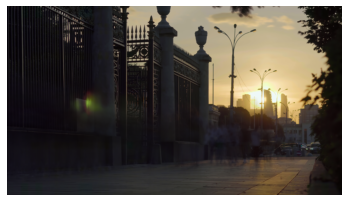

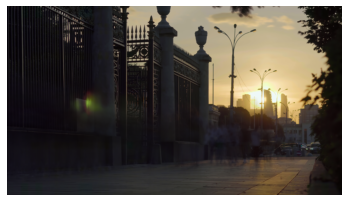

In [54]:
people2.compare(1e-8)